# <center> **PROJECT-3. EDA + Feature Engineering**
![booking logo](https://i1.wp.com/blog.keycafe.com/wp-content/uploads/2019/05/screen-shot-2017-10-24-at-9-54-22-am.png?w=1091&ssl=1)

## <center> **`1.` Постановка задачи**
**Проблематика:** одна из проблем компании — недобросовестные отели, которые обманывают со своим рейтингом. 

**Бизнес-задача:** один из способов найти такие отели — построить модель, предсказывающую рейтинг отеля. Если прогнозы модели сильно отличаются от фактического результата, возможно, отель играет нечестно и его следует проверить. Наша задача – создать такую ​​модель.

### <center> **ОРГАНИЗАЦИОННАЯ ИНФОРМАЦИЯ**

Наш проект будет состоять из четырёх частей:

`1.` **Постановка задачи**;

`2.` **Feature engineering** (*Создание новых признаков*);

`3.` **Отбор признаков**;

`4.` **Machine Learning** (*Строим модель*).

## <center> **`2.` Feature engineering (Создание новых признаков)**

Импортируем библиотеки

In [ ]:
# Для работы с DataFrame
import numpy as np
import pandas as pd
import datetime
import category_encoders as ce
import re
import nltk
import torch
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# Для создания и обучения модели
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics 

# Для рассчёта расстояния
from geopy.distance import geodesic as GD

# Для визуализации
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')

# LightAutoML
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

Прочитаем файл с исходными данными:

In [2]:
# Загружаем DataFrame
hotels_data = pd.read_csv('Прочие файлы/hotels.csv')

# Создаём копию данных
hotels_df = hotels_data.copy()

#### $Информация$ $о$ $датасете$
- `hotel_address` — адрес отеля;

- `review_date` — дата, когда рецензент разместил соответствующий отзыв;

- `average_score` — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

- `hotel_name` — название отеля;

- `reviewer_nationality` — страна рецензента;

- `negative_review` — отрицательный отзыв, который рецензент дал отелю;

- `review_total_negative_word_counts` — общее количество слов в отрицательном отзыве;

- `positive_review` — положительный отзыв, который рецензент дал отелю;

- `review_total_positive_word_counts` — общее количество слов в положительном отзыве.

- `reviewer_score` — оценка, которую рецензент поставил отелю на основе своего опыта;

- `total_number_of_reviews_reviewer_has_given` — количество отзывов, которые рецензенты дали в прошлом;

- `total_number_of_reviews` — общее количество действительных отзывов об отеле;

- `tags` — теги, которые рецензент дал отелю;

- `days_since_review` — количество дней между датой проверки и датой очистки;

- `additional_number_of_scoring` — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.

- `lat` — географическая широта отеля;

- `lng` — географическая долгота отеля.

In [ ]:
# Выведем первые пять строк датасета
hotels_df.head()

In [ ]:
# Выведем информацию о признаках
hotels_df.info()

In [ ]:
# Выведем информацию о пропусках
hotels_df.isnull().sum()

В данных присутствуют пропуски в следующих столбцах: 

* `lat` (2448 пропусков);
* `lng` (2448 пропусков).

Построем тепловую карту пропусков

lat    0.63288
lng    0.63288
dtype: float64


<AxesSubplot:>

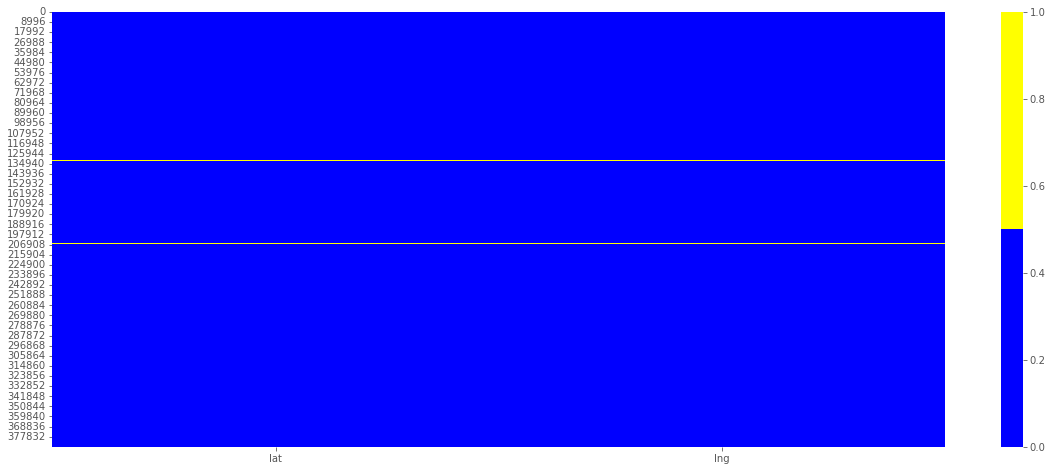

In [5]:
def missing_values_heatmap(data):
    
    # Рассчитываем количество пропусков
    cols_null_persent = data.isnull().mean() * 100
    cols_with_null = cols_null_persent[cols_null_persent > 0].sort_values(ascending = False)
    print(cols_with_null)
    
    # Задаём параметры графика
    colors = ['blue', 'yellow']
    fig = plt.figure(figsize = (20, 8))
    cols = cols_with_null.index
    
    # Строим тепловую карту
    ax = sns.heatmap(
        data = data[cols].isnull(),
        cmap = sns.color_palette(colors)
    )
    
    return ax


# Выводим тепловую карту
missing_values_heatmap(hotels_df)

#### $2.1$
Заполняем пропуски в данных

In [6]:
# Заполним пропущенные значения нулём
hotels_df['lat'].fillna(0, inplace=True)
hotels_df['lng'].fillna(0, inplace=True)

#### $2.2$
Признак `review_date`

In [7]:
# Переводим признак 'review_date' в dtype 'datetime'
hotels_df['review_date'] = pd.to_datetime(hotels_df['review_date'])

In [8]:
# Из признака 'review_date' выделяем года
hotels_df['review_year'] = 0

def get_year(row):
    row.review_year = row.review_date.strftime("%Y")
    return row

hotels_df = hotels_df.apply(lambda row: get_year(row), axis=1)
hotels_df['review_year'] = hotels_df['review_year'].astype(int)


# Из признака 'review_date' выделяем месяцы
hotels_df['review_month'] = 0

def get_month(row):
    row.review_month = row.review_date.strftime("%m")
    return row

hotels_df = hotels_df.apply(lambda row: get_month(row), axis=1)
hotels_df['review_month'] = hotels_df['review_month'].astype(int)


# Из признака 'review_date' выделяем дни
hotels_df['review_day'] = 0

def get_day(row):
    row.review_day = row.review_date.strftime("%d")
    return row

hotels_df = hotels_df.apply(lambda row: get_day(row), axis=1)
hotels_df['review_day'] = hotels_df['review_day'].astype(int)

#### $2.3$ 
Признак `days_since_review`

In [9]:
# Из признака 'days_since_review' извлекаем количество дней, и преобразовываем признак из dtype 'object' в dtype 'int'
def get_days(days):
    string_list = days.split(' ')
    days_count = string_list[0]
    return days_count

hotels_df['days_since_review'] = hotels_df['days_since_review'].apply(get_days).astype(int)

#### $2.4$ 
Признак `hotel_address`

In [ ]:
# Из признака 'hotel_address' выделяем название страны
def get_country_name(string):
    split_string = string.split(' ')
    country_name = split_string[-1]
    if split_string[-1] == 'Kingdom':
        country_name = split_string[-2] + ' ' + split_string[-1]
    return country_name

# Создаём признак, в котором будут указаны названия стран
hotels_df['country_name'] = hotels_df['hotel_address'].apply(get_country_name)



# Создаём признак 'city_name' 
def get_city_name(country):
    if country == 'United Kingdom':
        return 'London'
    elif country == 'Spain':
        return 'Barcelona'
    elif country == 'France':
        return 'Paris'
    elif country == 'Netherlands':
        return 'Amsterdam'
    elif country == 'Austria':
        return 'Vienna'
    else:
        return 'Milan'
    
# Создаём признак, в котором будут указаны названия городов
hotels_df['city_name'] = hotels_df['country_name'].apply(get_city_name)



# Создаём экземпляр класса OneHotEncoder()
encoder = ce.OneHotEncoder(cols=['city_name'])

# Кодируем признак 'city_name' с помощью класса OneHotEncoder()
type_bin = encoder.fit_transform(hotels_df['city_name'])

# Объединяем оба датасета
hotels_df = pd.concat([hotels_df, type_bin], axis=1)



# Переименовываем полученные признаки
hotels_df.rename(columns={
    'city_name_1': 'hotel_london',
    'city_name_2': 'hotel_paris',
    'city_name_3': 'hotel_amsterdam',
    'city_name_4': 'hotel_milan',
    'city_name_5': 'hotel_vienna',
    'city_name_6': 'hotel_barcelona'
}, inplace=True)

Построим распределение средней оценки в зависимости от города расположения отеля.

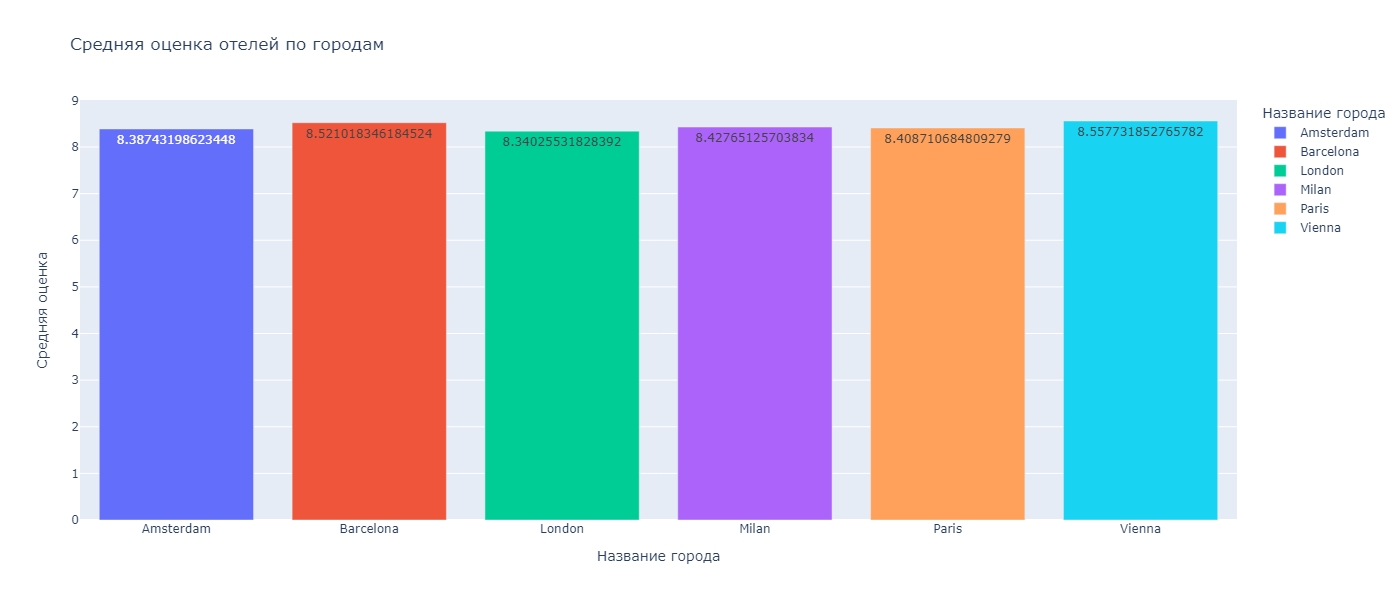

In [11]:
# Создаём DataFrame, в котором отразим зависимость средней оценки от города
bar_data1 = hotels_df.groupby(
    by = 'city_name',
    as_index = False
)[['average_score']].mean()


# Строим столбчатую диаграмму
fig = px.bar(
    data_frame = bar_data1,                      # DataFrame
    x = 'city_name',                             # распределение по оси x
    y = 'average_score',                         # распределение по оси y
    color = 'city_name',                         # цвет столбцов
    text = 'average_score',                      # текст на графике
    height = 600,                                # высота
    width = 1400,                                # ширина
    
    labels = {
        'city_name': 'Название города',          # название оси абсцисс
        'average_score': 'Средняя оценка'        # название оси ординат
    },
    
    title = 'Средняя оценка отелей по городам'   # название графика
)

# Выводим график
fig.show('png')

Построим распределение количества действительных отзывов в зависимости от города расположения отеля.

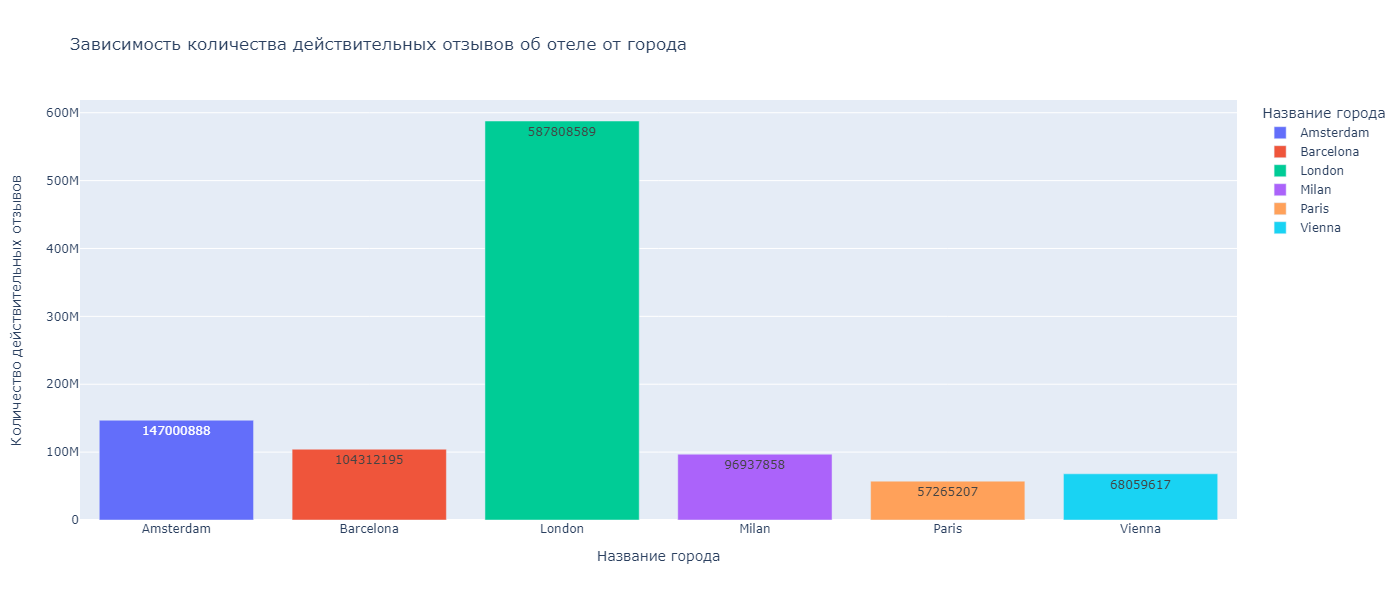

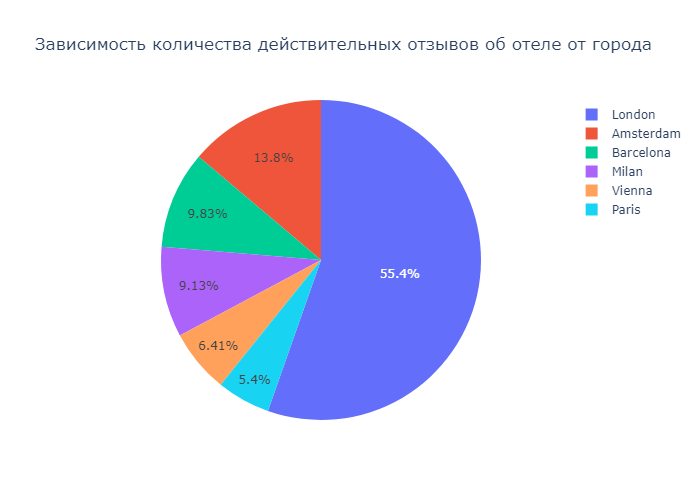

In [12]:
# Создаём DataFrame, в котором отразим зависимость количества действительных отзывов об отеле от города
bar_data2 = hotels_df.groupby(
    by = 'city_name',
    as_index = False
)[['total_number_of_reviews']].sum()


# Строим столбчатую диаграмму
fig = px.bar(
    data_frame = bar_data2,                                                        # DataFrame
    x = 'city_name',                                                               # распределение по оси x
    y = 'total_number_of_reviews',                                                 # распределение по оси y
    color = 'city_name',                                                           # цвет столбцов
    text = 'total_number_of_reviews',                                              # текст на графике
    height = 600,                                                                  # высота
    width = 1400,                                                                  # ширина
    
    labels = {
        'city_name': 'Название города',                                            # название оси абсцисс
        'total_number_of_reviews': 'Количество действительных отзывов'             # название оси ординат
    },
    
    title = 'Зависимость количества действительных отзывов об отеле от города'     # название графика
)

# Выводим график
fig.show('png')



# Строим круговую диаграмму
fig = px.pie(
    data_frame = bar_data2,                                                        # DataFrame
    values = 'total_number_of_reviews',                                            # значения на графике
    names = 'city_name',                                                           # названия городов
    labels = 'city_name',                                  
    title = 'Зависимость количества действительных отзывов об отеле от города'     # название графика
)


# Выводим график
fig.show('png')

**Вывод:** 

Как видно из построенных диаграмм, наивысший средний балл `8.56` наблюдается среди отелей *Вены*, тогда как наибольшее количество отзывов (`55.4%`) оставлены отелям *Лондона*.

#### $2.5$ 
Признаки `positive_review` и `negative_review`

In [13]:
# Создание экземпляра класса SentimentIntensityAnalyzer()
sent_analyzer = SentimentIntensityAnalyzer()

# Производим анализ каждого обзора
def get_review_analysis(review):
    return sent_analyzer.polarity_scores(review)

hotels_df['positive_review_analysis'] = hotels_df['positive_review'].apply(get_review_analysis)

In [14]:
# Создаём отдельные признаки из получившихся ключей: 'neg', 'neu', 'pos', 'compound'

hotels_df['neg_review_sentiments_pos'] = hotels_df['positive_review_analysis'].apply(lambda x: x['neg'])
hotels_df['neg_review_sentiments_pos'] = hotels_df['neg_review_sentiments_pos'].round().astype(int)

hotels_df['neu_review_sentiments_pos'] = hotels_df['positive_review_analysis'].apply(lambda x: x['neu'])
hotels_df['neu_review_sentiments_pos'] = hotels_df['neu_review_sentiments_pos'].round().astype(int)

hotels_df['pos_review_sentiments_pos'] = hotels_df['positive_review_analysis'].apply(lambda x: x['pos'])
hotels_df['pos_review_sentiments_pos'] = hotels_df['pos_review_sentiments_pos'].round().astype(int)

hotels_df['compound_review_sentiments_pos'] = hotels_df['positive_review_analysis'].apply(lambda x: x['compound'])
hotels_df['compound_review_sentiments_pos'] = hotels_df['compound_review_sentiments_pos'].round().astype(int)

In [15]:
def get_review_analysis(review):
    return sent_analyzer.polarity_scores(review)

hotels_df['negative_review_analysis'] = hotels_df['negative_review'].apply(get_review_analysis)

In [12]:
# Создаём отдельные признаки из получившихся ключей: 'neg', 'neu', 'pos', 'compound'

hotels_df['neg_review_sentiments_neg'] = hotels_df['negative_review_analysis'].apply(lambda x: x['neg'])
hotels_df['neg_review_sentiments_neg'] = hotels_df['neg_review_sentiments_neg'].round().astype(int)

hotels_df['neu_review_sentiments_neg'] = hotels_df['negative_review_analysis'].apply(lambda x: x['neu'])
hotels_df['neu_review_sentiments_neg'] = hotels_df['neu_review_sentiments_neg'].round().astype(int)

hotels_df['pos_review_sentiments_neg'] = hotels_df['negative_review_analysis'].apply(lambda x: x['pos'])
hotels_df['pos_review_sentiments_neg'] = hotels_df['pos_review_sentiments_neg'].round().astype(int)

hotels_df['compound_review_sentiments_neg'] = hotels_df['negative_review_analysis'].apply(lambda x: x['compound'])
hotels_df['compound_review_sentiments_neg'] = hotels_df['compound_review_sentiments_neg'].round().astype(int)

#### $2.6$ 
Признак `lat_city` (*географическая широта города*)

In [13]:
# Создаём функцию для присваивания каждому городу его широты
def get_lat_city(city):
    if city == 'London':
        return 51.508530
    if city == 'Barcelona':
        return 41.388790
    if city == 'Paris':
        return 48.853410
    if city == 'Amsterdam':
        return 52.374030
    if city == 'Vienna':
        return 48.208490
    if city == 'Milan':
        return 45.464270
    
# Применяем полученную функцию к признаку 'hotel_city_name'
hotels_df['lat_city'] = hotels_df['city_name'].apply(get_lat_city)

#### $2.7$ 
Признак `lng_city` (*географическая долгота города*)

In [14]:
# Создаём функцию для присваивания каждому городу его долготы
def get_lng_city(city):
    if city == 'London':
        return -0.125740
    if city == 'Barcelona':
        return 2.158990
    if city == 'Paris':
        return 2.348800
    if city == 'Amsterdam':
        return 4.889690
    if city == 'Vienna':
        return 16.372080
    if city == 'Milan':
        return 9.189510
    
# Применяем полученную функцию к признаку 'hotel_city_name'
hotels_df['lng_city'] = hotels_df['city_name'].apply(get_lng_city)

#### $2.8$ 
Признак `hotel_distance_to_center` (*расстояние от отеля до центра города*)

In [15]:
# Используем метод геодезического расстояния с помощью метода geodesic
hotels_df['hotel_distance_to_center'] = 0

def get_distance(row):
    row.hotel_distance_to_center = GD([row.lat_city, row.lng_city], [row.lat, row.lng]).km
    return row

# Создаём признак расстояния от отеля до центра города
hotels_df = hotels_df.apply(lambda row: get_distance(row), axis=1)

# Заменим высокие значения расстояния на 0
def change_to_zero(coordinate):
    if coordinate > 100:
        return 0
    else:
        return coordinate
    
    
hotels_df['hotel_distance_to_center'] = hotels_df['hotel_distance_to_center'].apply(change_to_zero)

#### $2.9$ 
Признак `reviewer_nationality`

In [16]:
# Создаём функцию для удаления первого и последнего пробела в строках
def delite_spaces(string):
    return string[1:-1]

# Применяем полученную функцию к признаку 'reviewer_nationality'
hotels_df['reviewer_nationality'] = hotels_df['reviewer_nationality'].apply(delite_spaces)

In [17]:
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Создаём признак 'reviewer_nationality_num'
hotels_df['reviewer_nationality_num'] = lab_enc.fit_transform(hotels_df['reviewer_nationality'])

In [18]:
# Создаём признак принадлежности рецензента к стране с отелем
hotels_df['reviewer_is_citizen'] = 0

def rev_is_cit(row):
    if row.reviewer_nationality == row.country_name:
        row.reviewer_is_citizen = 1
    else:
        row.reviewer_is_citizen = 0
    return row

# Применяем полученную функцию ко всему датафрейму
hotels_df = hotels_df.apply(lambda row: rev_is_cit(row), axis=1)

In [19]:
# Создаём экземпляр класса BinaryEncoder()
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])

# Кодируем признак 'reviewer_nationality' с помощью класса BinaryEncoder()
type_bin = bin_encoder.fit_transform(hotels_df['reviewer_nationality'])

# Объединяем оба датасета
hotels_df = pd.concat([hotels_df, type_bin], axis=1)

#### $2.10$ 
Признак `tags`

In [20]:
# Конвертируем строки признака 'tags' в списки
def re_func(list_tags):
    found = re.findall("'[^\'](.+?)[^\']'", list_tags)
    return found

hotels_df['tags'] = hotels_df['tags'].apply(re_func)

In [21]:
# Создаём признак 'count_tags' (количество тегов)
def get_tags_count(list_tags):
    return len(list_tags)

hotels_df['count_tags'] = hotels_df['tags'].apply(get_tags_count)

Создаём признаки классификации типа поездки

In [ ]:
# Создаём признак 'type_of_trip' (Выделяем тип поездки)
def get_type(list):
    for tag in list:
        if 'Business trip' in tag:
            return 'Business trip'
        elif 'Leisure trip' in tag:
            return 'Leisure trip'
    else:
        return 'Unknown trip'
    
hotels_df['type_of_trip'] = hotels_df['tags'].apply(get_type)



# Создаём экземпляр класса OneHotEncoder()
encoder_type = ce.OneHotEncoder(cols=['type_of_trip'])

# Кодируем признак 'type_of_trip' с помощью класса OneHotEncoder()
type_bin_type = encoder_type.fit_transform(hotels_df['type_of_trip'])

# Объединяем оба датасета
hotels_df = pd.concat([hotels_df, type_bin_type], axis=1)



# Переименовываем полученные признаки
hotels_df.rename(columns={
    'type_of_trip_1': 'leisure_trip',
    'type_of_trip_2': 'business_trip',
    'type_of_trip_3': 'unknown_trip'
}, inplace=True)

Создаём признаки классификации типа комнат

In [ ]:
# Выделяем из тэгов все типы комнат, и создаём признак 'hotel_rooms'
def get_rooms(list):
    for tag in list:
        if 'room' in tag:
            return tag
        elif 'Room' in tag:
            return tag
    else:
        return 'Unknown room'
    
hotels_df['hotel_rooms'] = hotels_df['tags'].apply(get_rooms)



# Выделяем типы комнат, в которые чаще всего заселяются и создаём признак 'hotel_rooms_class'
rooms_list = [
    'Double Room',
    'Standard Double Room',
    'Superior Double Room'
]

def get_room_class(room):
    if room in rooms_list:
        return room
    else:
        return 'Other'
    
hotels_df['hotel_rooms_class'] = hotels_df['hotel_rooms'].apply(get_room_class)



# Создаём экземпляр класса OneHotEncoder()
encoder_room = ce.OneHotEncoder(cols=['hotel_rooms_class'])

# Кодируем признак 'hotel_rooms_class' с помощью класса OneHotEncoder()
type_bin_room = encoder_room.fit_transform(hotels_df['hotel_rooms_class'])

# Объединяем оба датасета
hotels_df = pd.concat([hotels_df, type_bin_room], axis=1)



# Переименовываем полученные признаки
hotels_df.rename(columns={
    'hotel_rooms_class_1': 'other_rooms',
    'hotel_rooms_class_2': 'standard_double_room',
    'hotel_rooms_class_3': 'superior_double_room',
    'hotel_rooms_class_4': 'double_room'
}, inplace=True)

Создаём признаки классификации группы поездки

In [ ]:
# Выделяем из тэгов категории групп туристов. Создаём признак 'group_class'
def get_group(list):
    for tag in list:
        if 'Couple' in tag:
            return 'Couple'
        elif 'Family with older children' in tag:
            return 'Family with older children'
        elif 'Family with young children' in tag:
            return 'Family with young children'
        elif 'Group' in tag:
            return 'Group'
        elif 'Solo traveler' in tag:
            return 'Solo traveler'
        elif 'Travelers with friends' in tag:
            return 'Travelers with friends'
        elif 'With a pet' in tag:
            return 'With a pet'
    else:
        return 'Unknown group'
    
hotels_df['group_class'] = hotels_df['tags'].apply(get_group)



# Создаём экземпляр класса OneHotEncoder()
encoder_group = ce.OneHotEncoder(cols=['group_class'])

# Кодируем признак 'group_class' с помощью класса OneHotEncoder()
type_bin_group = encoder_group.fit_transform(hotels_df['group_class'])

# Объединяем оба датасета
hotels_df = pd.concat([hotels_df, type_bin_group], axis=1)



# Переименовываем полученные признаки
hotels_df.rename(columns={
    'group_class_1': 'trip_couple',
    'group_class_2': 'trip_solo',
    'group_class_3': 'trip_with_young_children',
    'group_class_4': 'trip_group',
    'group_class_5': 'trip_with_older_children',
    'group_class_6': 'trip_with_friends',
    'group_class_7': 'trip_with_a_pet'
}, inplace=True)

Создаём признаки, классифицирующие количества проведённых ночей

In [25]:
# Выделяем тэги, обозначающие количества проведённых ночей в отеле. Создаём признак 'length_of_stay'
def nights_count(list):
    for tag in list:
        if 'Stayed' in tag.split(' '):
            return tag
    else:
        return 'Unknown number'
    
hotels_df['length_of_stay'] = hotels_df['tags'].apply(nights_count)

In [ ]:
count_of_nights_list = [
    'Stayed 1 night',
    'Stayed 2 nights',
    'Stayed 3 nights',
    'Stayed 4 nights',
    'Stayed 5 nights'
]

# Создаём функцию, которая будет возвращать тэг из списка (если будет найдено соответствие),
# либо строку 'more then 5 nights'
def get_nights_count(tag):
    if tag in count_of_nights_list:
        return tag
    else:
        return 'more then 5 nights'

hotels_df['nights_classification'] = hotels_df['length_of_stay'].apply(get_nights_count)



# Создаём экземпляр класса OneHotEncoder()
encoder = ce.OneHotEncoder(cols=['nights_classification'])

# Кодируем признак 'nights_classification' с помощью класса OneHotEncoder()
type_bin = encoder.fit_transform(hotels_df['nights_classification'])

# Объединяем оба датасета
hotels_df = pd.concat([hotels_df, type_bin], axis=1)



# Переименовываем полученные признаки
hotels_df.rename(columns={
    'nights_classification_1': 'stayed_2_nights',
    'nights_classification_2': 'stayed_1_night',
    'nights_classification_3': 'stayed_3_nights',
    'nights_classification_4': 'stayed_more_than_5_nights',
    'nights_classification_5': 'stayed_4_nights',
    'nights_classification_6': 'stayed_5_nights'
}, inplace=True)

Создаём признаки, классифицирующие помещения

In [ ]:
# Выделяем тэги, обозначающие размеры помещений. Создаём признак 'size_of_apartments'
def get_size(list):
    for tag in list:
        if 'tandard' in tag:
            return 'Standard'
        elif 'edroom' in tag:
            return 'Bedroom'
        elif 'uperior' in tag:
            return 'Superior'
        elif 'tudio' in tag:
            return 'Studio'
        elif 'amily room' in tag:
            return 'Family room'
        elif 'uite' in tag:
            return 'Suite'
        elif 'uplex' in tag:
            return 'Duplex'
        elif 'partment' in tag:
            return 'Apartment'
    else:
        return 'Other'
        
hotels_df['size_of_apartments'] = hotels_df['tags'].apply(get_size)



# Создаём экземпляр класса OneHotEncoder()
encoder_size = ce.OneHotEncoder(cols=['size_of_apartments'])

# Кодируем признак 'size_of_apartments' с помощью класса OneHotEncoder()
type_bin_size = encoder_size.fit_transform(hotels_df['size_of_apartments'])

# Объединяем оба датасета
hotels_df = pd.concat([hotels_df, type_bin_size], axis=1)



# Переименовываем полученные признаки
hotels_df.rename(columns={
    'size_of_apartments_1': 'studio_class',
    'size_of_apartments_2': 'standard_class',
    'size_of_apartments_3': 'other_class',
    'size_of_apartments_4': 'superior_class',
    'size_of_apartments_5': 'bedroom_class',
    'size_of_apartments_6': 'suite_class',
    'size_of_apartments_7': 'apartment_class',
    'size_of_apartments_8': 'duplex_class',
    'size_of_apartments_9': 'family_room_class'
}, inplace=True)

Создаём признаки, классифицирующие размеры помещений

In [ ]:
# Выделяем тэги, обозначающие варианты размещений. Создаём признак 'accommodation_options'
def get_number_guests(list):
    for tag in list:
        if 'ingle' in tag:
            return 'Single'
        elif 'ouble' in tag:
            return 'Double'
        elif 'riple' in tag:
            return 'Triple'
    else:
        return 'Unknown'
    
hotels_df['accommodation_options'] = hotels_df['tags'].apply(get_number_guests)



# Создаём экземпляр класса OneHotEncoder()
encoder_options = ce.OneHotEncoder(cols=['accommodation_options'])

# Кодируем признак 'accommodation_options' с помощью класса OneHotEncoder()
type_bin_options = encoder_options.fit_transform(hotels_df['accommodation_options'])

# Объединяем оба датасета
hotels_df = pd.concat([hotels_df, type_bin_options], axis=1)



# Переименовываем полученные признаки
hotels_df.rename(columns={
    'accommodation_options_1': 'unknown_option',
    'accommodation_options_2': 'double_option',
    'accommodation_options_3': 'triple_option',
    'accommodation_options_4': 'single_option'
}, inplace=True)

Создаём признаки с классификацией размеров кроватей

In [ ]:
# Выделяем тэги, обозначающие размеры кравати в номере. Создаём признак 'bed_size'
def get_bed_size(list):
    for tag in list:
        if 'Double Bed' in tag:
            return 'Double Bed'
        elif 'Queen Bed' in tag:
            return 'Queen Bed'
        elif 'Queensize Bed' in tag:
            return 'Queen Bed'
        elif 'Queen size Bed' in tag:
            return 'Queen Bed'
        elif 'Queen Room' in tag:
            return 'Queen Bed'
        elif 'Twin Bed' in tag:
            return 'Twin Bed'
        elif 'Sofa Bed' in tag:
            return 'Sofa Bed'
        elif 'Single Bed' in tag:
            return 'Single Bed'
        elif ' King' in tag:
            return 'King Bed'
    else:
        return 'Other Beds'
    
hotels_df['bed_size'] = hotels_df['tags'].apply(get_bed_size)



# Создаём экземпляр класса OneHotEncoder()
encoder = ce.OneHotEncoder(cols=['bed_size'])

# Кодируем признак 'bed_size' с помощью класса OneHotEncoder()
type_bin = encoder.fit_transform(hotels_df['bed_size'])

# Объединяем оба датасета
hotels_df = pd.concat([hotels_df, type_bin], axis=1)



# Переименовываем полученные признаки
hotels_df.rename(columns={
    'bed_size_1': 'other_beds',
    'bed_size_2': 'double_bed',
    'bed_size_3': 'king_bed',
    'bed_size_4': 'queen_bed',
    'bed_size_5': 'single_bed',
    'bed_size_6': 'sofa_bed',
    'bed_size_7': 'twin_bed'
}, inplace=True)

#### $2.11$ 
Удаляем ненужные признаки

In [30]:
# Удаляем признаки типа object
object_columns = [features for features in hotels_df.columns if hotels_df[features].dtype == 'object']
hotels_df.drop(object_columns, axis=1, inplace=True)

# Удаляем признак 'review_date'
hotels_df = hotels_df.drop('review_date', axis=1)

In [ ]:
# Выводим информацию получившегося датасета
hotels_df.info()

In [ ]:
# Выводим информацию о пропусках получившегося датасета
hotels_df.isnull().sum()

## <center> **`3.` Отбор признаков**

#### $3.1$ 
Строим график распределения признаков

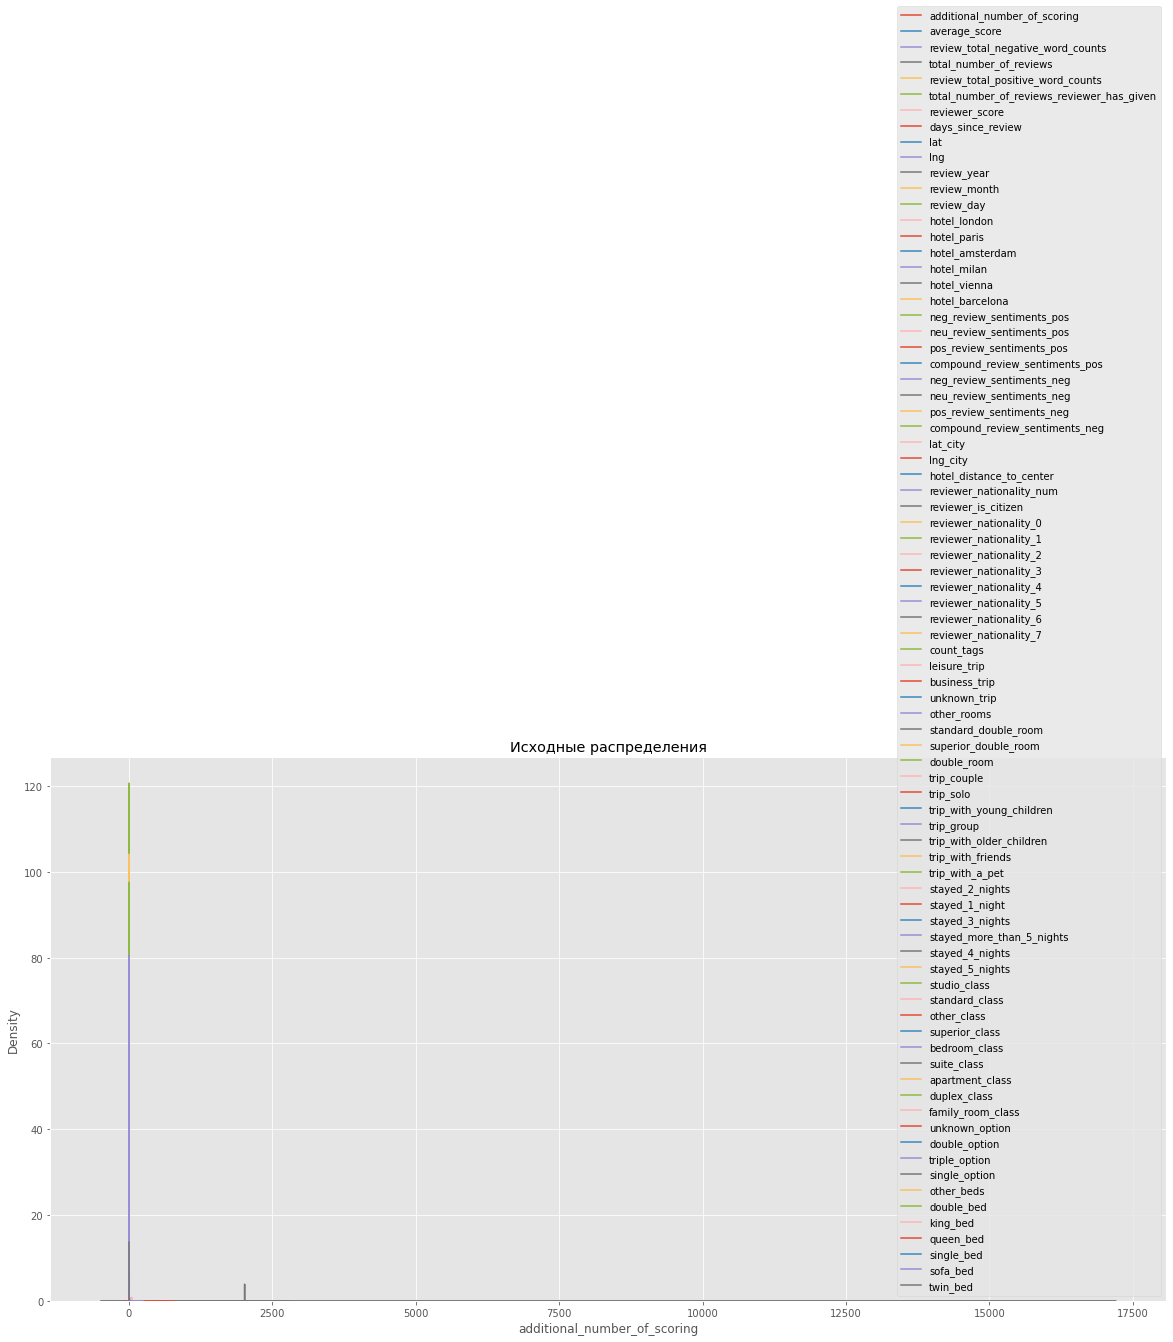

In [31]:
# Задаём параметры графика
fig, (ax) = plt.subplots(ncols = 1, figsize = (20, 10))

# Название графика
ax.set_title('Исходные распределения')

# Строим график
for column in hotels_df.columns:
    sns.kdeplot(hotels_df[column], ax=ax, label=column)
    

# Выводим график
plt.legend()

Из полученного графика можно сделать вывод, что признаки в основном распределены нормально. Следовательно ни нормализация ни стандартизация данным признакам не требуется.

In [ ]:
# Выведем описание всех признаков
hotels_df.describe()

#### $3.2$ 
Проводим корреляционный анализ

Построим тепловую карту корреляций признаков.

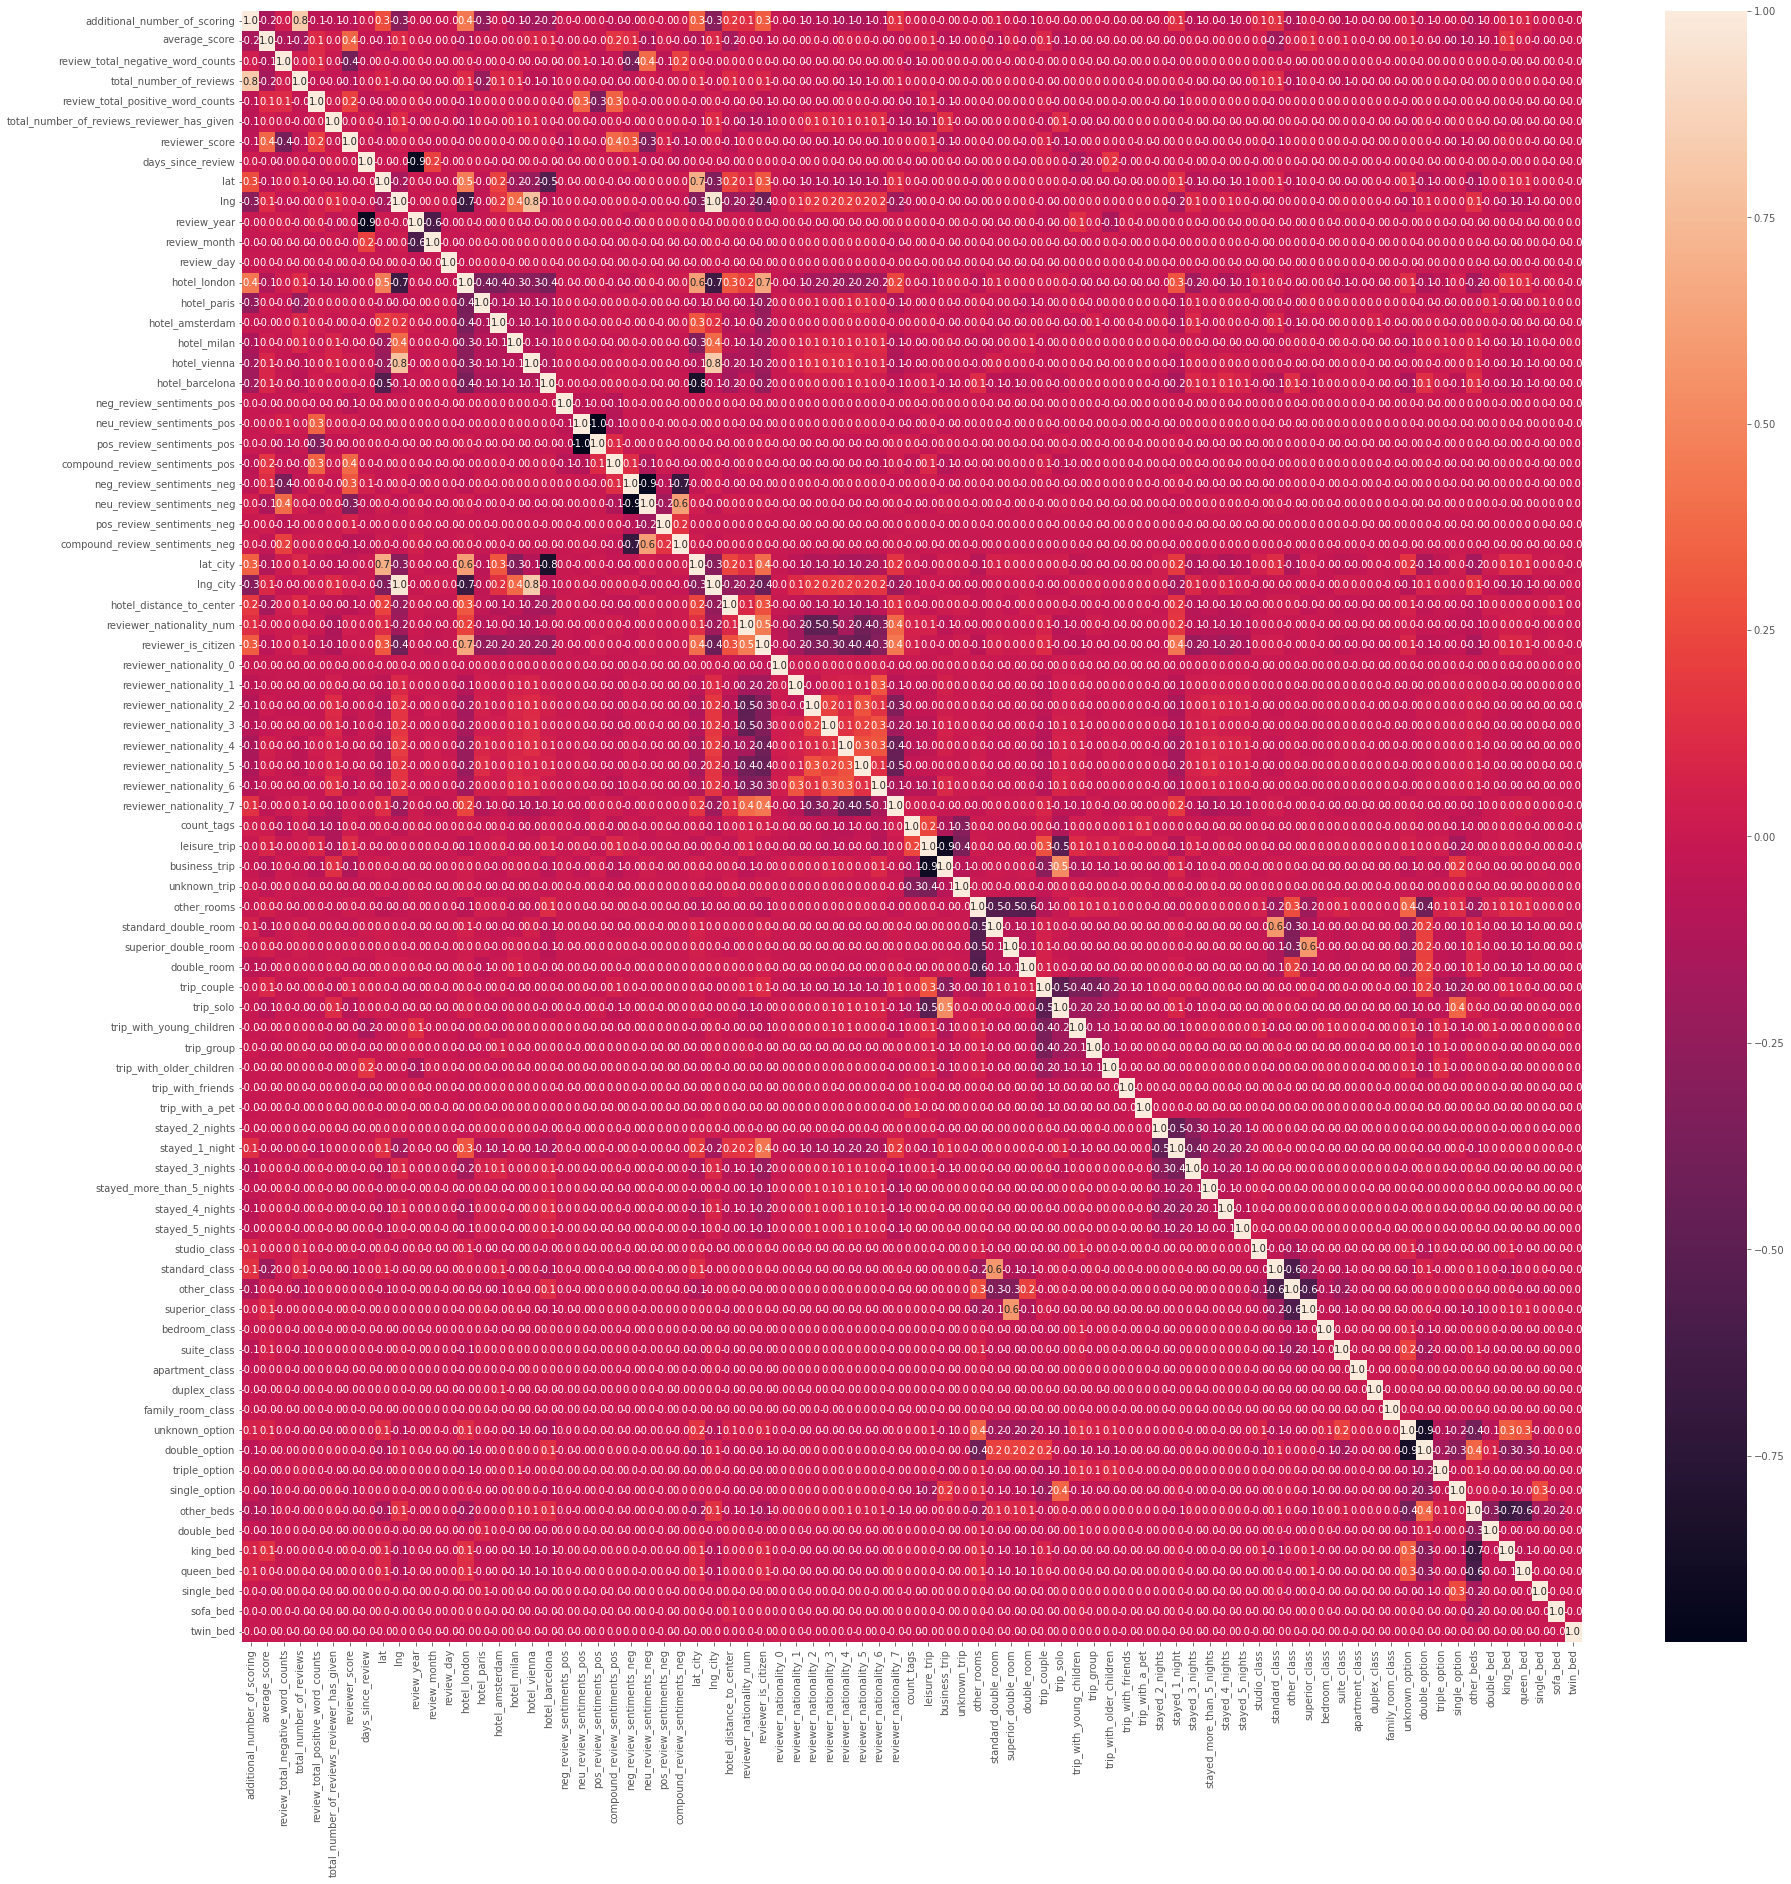

In [37]:
plt.rcParams['figure.figsize'] = (30, 30)
sns.heatmap(hotels_df.corr(), annot=True, fmt='.1f');

Удаляем признаки с высокой корреляцией

In [39]:
hotels_df = hotels_df.drop([
    'additional_number_of_scoring',
    'days_since_review',
    'hotel_vienna',
    'lng_city',
    'pos_review_sentiments_pos',
    'neg_review_sentiments_neg',
    'lat',
    'business_trip',
    'double_option',
    'hotel_barcelona',
    'lng'
], axis=1)

Для того, чтобы убедиться в отсутствии высококоррелированных связей между признаками повторно выводим тепловую карту

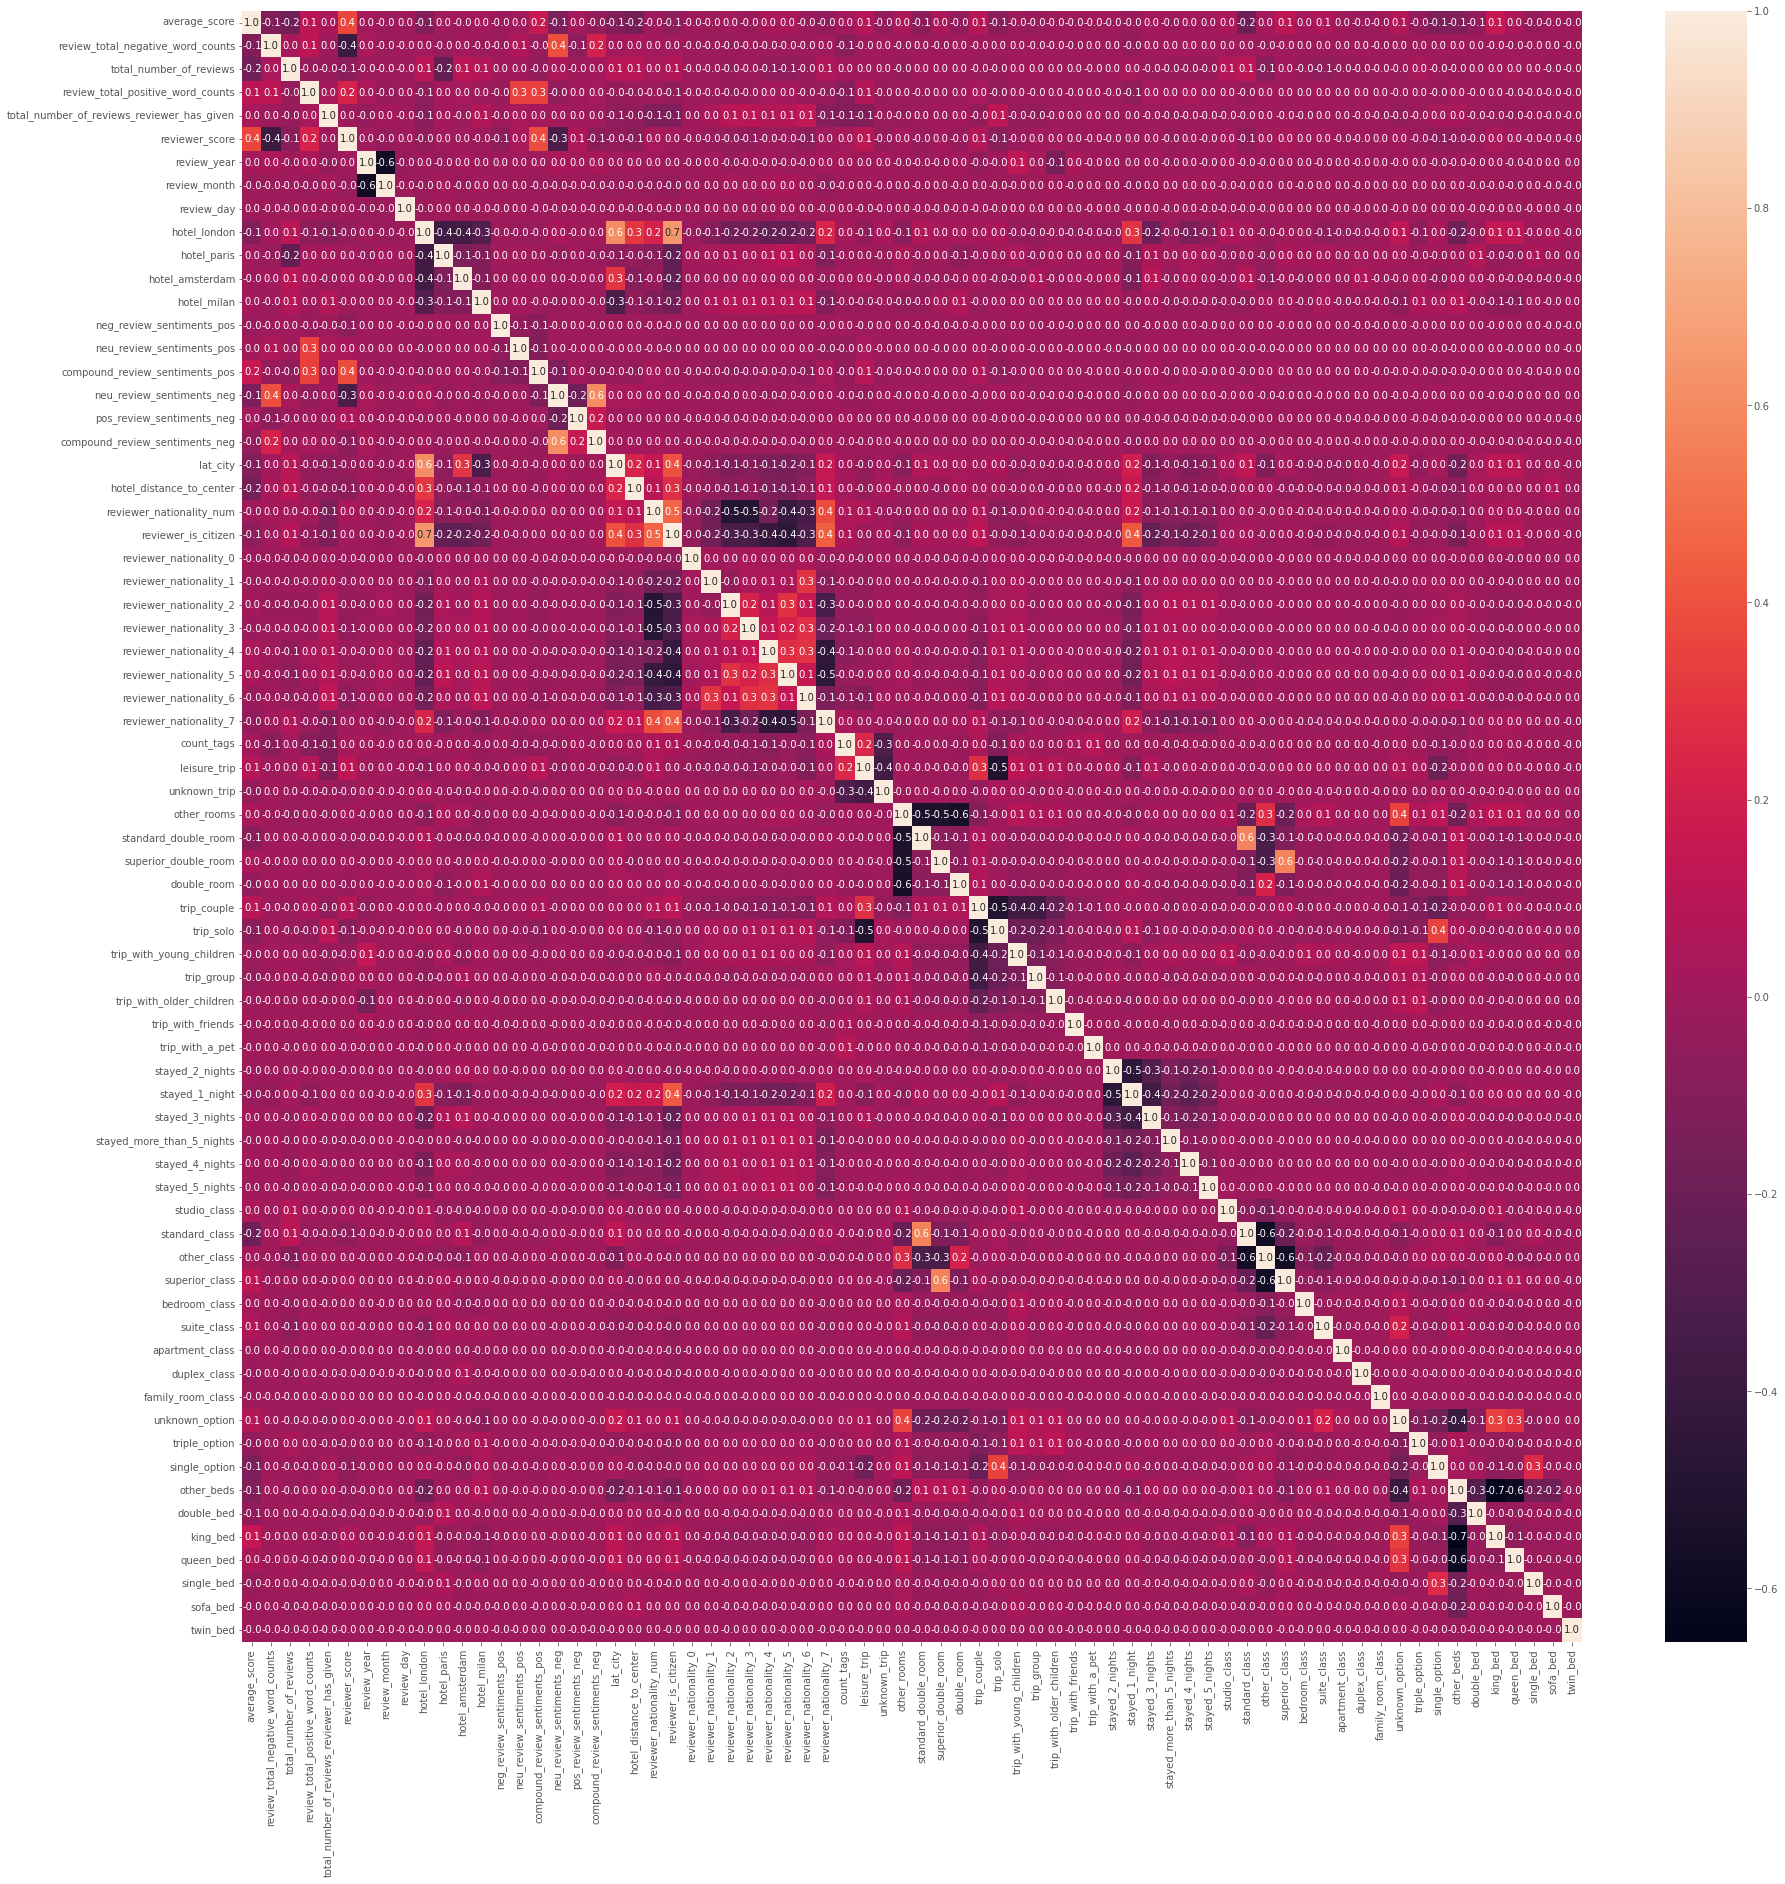

In [41]:
plt.rcParams['figure.figsize'] = (30, 30)
sns.heatmap(hotels_df.corr(), annot=True, fmt='.1f');

## <center> **`4.` Machine Learning (Строим модель)**

#### $4.1$
Разделим данные

In [60]:
# Составляем список факторов (исключили целевой столбец)
features = hotels_df.drop('reviewer_score', axis=1).columns

# Составляем матрицу наблюдений X и вектор правильных ответов y
X = hotels_df[features]
y = hotels_df['reviewer_score']

Определяем константы (количество потоков, таймаут, имя целевой колонки, размер валидационной выборки и так далее).

In [61]:
# Опредиляем константы для lightautoml
N_THREADS = 10
N_FOLDS = 10
RANDOM_STATE = 42
TEST_SIZE = 0.3
TIMEOUT = 600
TARGET_NAME = 'reviewer_score'

Для максимальной воспроизводимости решения используем команды: 

In [62]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

#### $4.2$
Разбиваем данные на тренировочную (80 %, tr_data) и валидационную (20 %, te_data) выборки.

In [63]:
train_data, test_data = train_test_split(
    hotels_df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [ ]:
# Выведем размеры тренировочной и тестовой части
print(f'Данные разделены. Размеры каждой части: train_data = {train_data.shape}, test_data = {test_data.shape}')

In [ ]:
# Выведем первые пять строк тренировочной части
train_data.head()

Указываем задачу, которую решаем (задача регрессии 'reg') и указываем метрику ('mae')

In [66]:
task = Task('reg', loss='mae', metric='mae')

Указываем роли переменных

In [67]:
roles = {
    'target': TARGET_NAME,
    'drop': []
}

#### $4.3$
С помощью класса TabularAutoML создаём модель LightAutoML

In [68]:
automl = TabularAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

#### $4.4$
Обучение тренировочной выборки

In [ ]:
oof_pred = automl.fit_predict(train_data=train_data, roles=roles, verbose=1)

In [ ]:
# Выводим информацию об автоматической обработке
print(automl.create_model_str_desc())

С помощью метода fast построим график, на котором отобразим оценку влияния каждого признака на полученные предсказания.

<AxesSubplot:xlabel='Feature'>

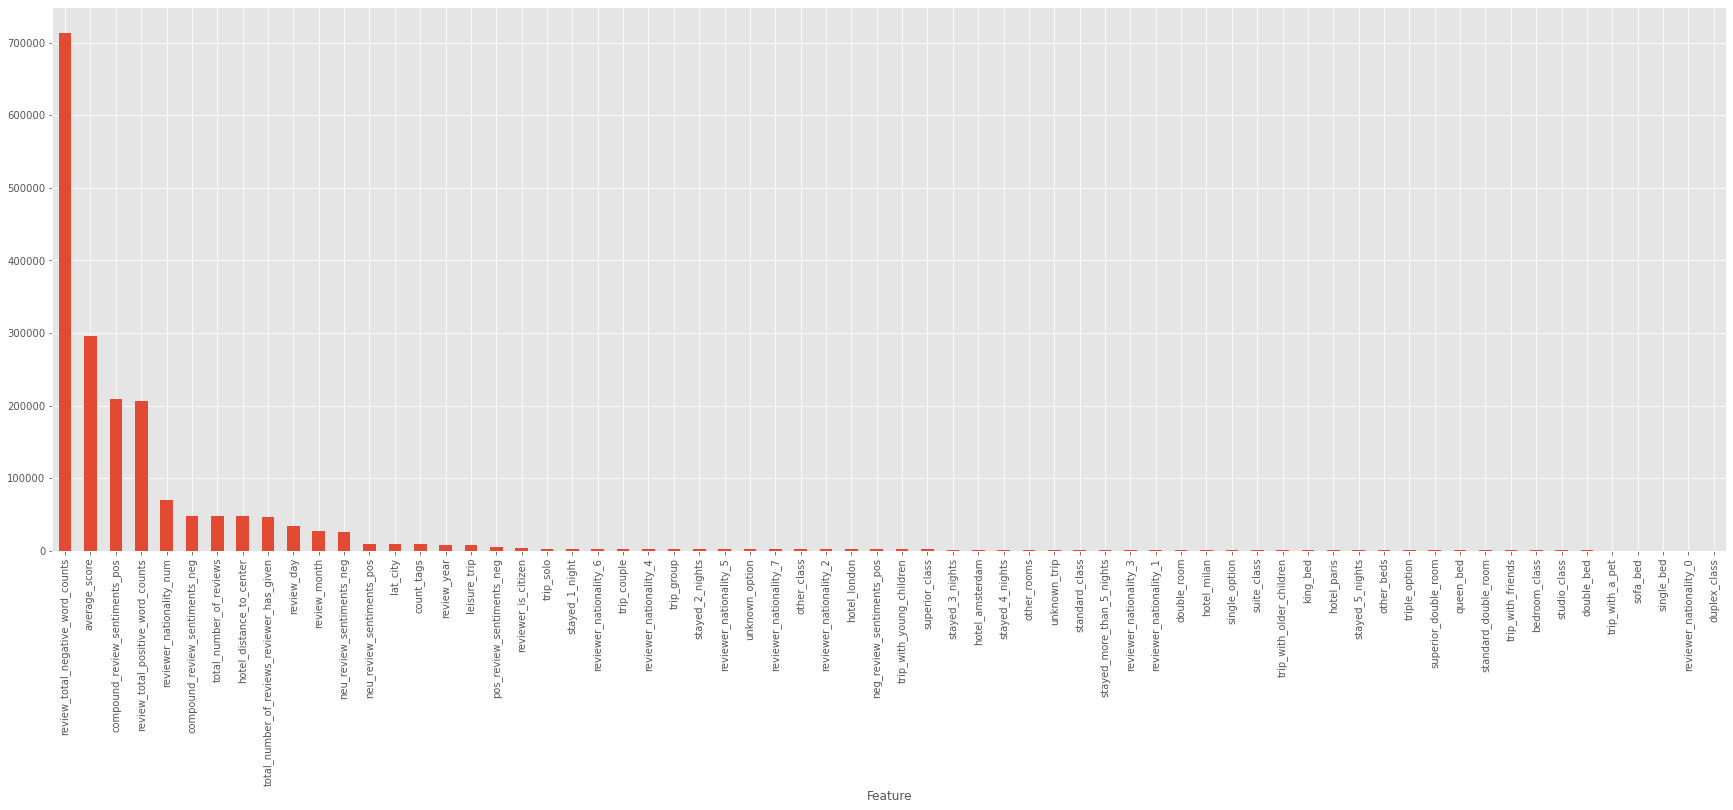

In [73]:
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

#### $4.5$
Обучение валидационной выборки

In [ ]:
test_pred = automl.predict(test_data)
print(f'Предсказание для test_data:\n{test_pred}\nShape = {test_pred.shape}')

In [75]:
# Сравниваем предсказанные значения (test_pred) с реальными (test_data), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(test_data[TARGET_NAME].values, test_pred.data[:, 0]))

MAPE: 0.12470756707515762


## <center> **`5.` Вывод**

По окончании обработки данных исходная метрика *MAPE* была снижена на `0,0166732966512264`. Итоговая метрика *MAPE* составила `0.12470756707515762`.